In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Paths, RIS, r_hat, normalize
from sionna import PI

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement


In [3]:

# Load integrated scene
scene = load_scene("oulu_downtown_scene/untitled.xml") # Try also sionna.rt.scene.etoile
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter 
tx = Transmitter("tx", position=[-25,35,12])
scene.add(tx)

# Place receivers
rx1 = Receiver("rx1", position=[60,-50,3])
scene.add(rx1)
rx2 = Receiver("rx2", position=[109,-43,3])
scene.add(rx2)

# Place RIS
ris1 = RIS(name="ris1",
          position=[64,55,30],
          num_rows=100,
          num_cols=100,
          num_modes=2,
          look_at=(tx.position+rx1.position)/2) # Look in between TX and RX1
scene.add(ris1)

ris2 = RIS(name="ris2",
          position=[-15,-50,20],
          num_rows=100,
          num_cols=100,
          num_modes=2,
          look_at=(tx.position+rx2.position)/2) # Look in between TX and RX2
scene.add(ris2)



In [4]:
# Visualize scene
if no_preview:
    if scene.get("cam") is None:
        scene.add(Camera("cam",
                         position=[50,-50,130],
                         look_at=[0,0,0]))
    scene.render(camera="cam", num_samples=512);


In [5]:


scene.preview(show_orientations=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [6]:
path = scene.compute_paths(ris=True, los=False,max_depth=3,)
scene.preview(show_orientations=True,paths=path)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

In [7]:
# Make the phase profile trainable
# Initialize all phases to zero
ris1.phase_profile.values = tf.Variable(tf.zeros_like(ris1.phase_profile.values))
ris2.phase_profile.values = tf.Variable(tf.zeros_like(ris2.phase_profile.values))

# Create trainable variables for the amplitude profile
# to which some normalization will be applied in the training loop.
# Initialize all values to one and ensure that the gradient update can
# never make the values negative.
a1 = tf.Variable(tf.ones_like(ris1.amplitude_profile.values),
                 constraint=lambda x: tf.abs(x))
a2 = tf.Variable(tf.ones_like(ris2.amplitude_profile.values),
                 constraint=lambda x: tf.abs(x))

# Make mode powers trainable
# to which some normalization will be applied in the training loop.
# We cannot set them to zero as the gradient is infinitely large at this point.
# Ensure that gradient updates can never bring the mode powers
# out of their desired range.
m1 = tf.Variable([0.99, 0.01], dtype=tf.float32,
                 constraint=lambda x: tf.clip_by_value(x, 0.01, 1))
m2 = tf.Variable([0.99, 0.01], dtype=tf.float32,
                 constraint=lambda x: tf.clip_by_value(x, 0.01, 1))

In [8]:
# Define an optimizer
optimizer = tf.keras.optimizers.Adam(0.5)

# Helper function to compute dB
def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)

# Define a training step
def train_step():
    with tf.GradientTape() as tape:

        # Set amplitude profile values while ensuring an average power of one
        ris1.amplitude_profile.values = a1/tf.sqrt(tf.reduce_mean(a1**2, axis=[1,2], keepdims=True))
        ris2.amplitude_profile.values = a2/tf.sqrt(tf.reduce_mean(a2**2, axis=[1,2], keepdims=True))

        # Set mode powers while ensuring a total power of one
        ris1.amplitude_profile.mode_powers = m1/tf.reduce_sum(m1)
        ris2.amplitude_profile.mode_powers = m2/tf.reduce_sum(m2)
        
        # Compute paths
        paths = scene.compute_paths()

        # Convert to baseband-equivalent channel impulse response
        # Get rid of all unused dimensions
        # [num_rx=2, num_tx=2]
        #import ipdb; ipdb.set_trace()
        a = tf.squeeze(paths.cir()[0])
        
        # Compute average paths gain per RX
        path_gain = to_db(tf.reduce_mean(tf.reduce_sum(tf.abs(a)**2, axis=-1)))
        loss = -path_gain
    
    # Compute gradients with the goal of maximizing the path gain
    grads = tape.gradient(loss, tape.watched_variables())
    # Apply optimizer
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
   
    return path_gain, a

In [9]:
# Create a storage tensor for intermediate results

a_it = tf.zeros([0, 2, 4], dtype=tf.complex64)

# Run training iterations
num_iterations = 100
for i in range(num_iterations):
    path_gain, a = train_step()
    #print(i, a_it.shape,a.shape)
    a_it = tf.concat([a_it, a[tf.newaxis]], axis=0)
    if i%10==0 or i==0:
        print(f"Iteration {i} - Path gain: {path_gain.numpy():.2f}dB")        

Iteration 0 - Path gain: -99.73dB
Iteration 10 - Path gain: -75.34dB
Iteration 20 - Path gain: -74.04dB
Iteration 30 - Path gain: -73.50dB
Iteration 40 - Path gain: -73.30dB
Iteration 50 - Path gain: -73.17dB
Iteration 60 - Path gain: -73.07dB
Iteration 70 - Path gain: -73.01dB
Iteration 80 - Path gain: -72.97dB
Iteration 90 - Path gain: -72.95dB


In [10]:
a_it[:,1,3]

<tf.Tensor: shape=(100,), dtype=complex64, numpy=
array([-1.0591656e-07-1.0511302e-06j, -5.9079503e-06-5.6011435e-05j,
       -6.7260294e-06-6.5256492e-05j, -5.6181002e-06-5.6282312e-05j,
       -3.9214456e-06-4.1007712e-05j, -2.9853325e-06-3.2865817e-05j,
       -1.9641943e-06-2.3150875e-05j, -1.4391183e-06-1.8237026e-05j,
       -8.8596539e-07-1.3121400e-05j, -4.4121418e-07-9.7933971e-06j,
       -6.6052962e-08-7.0183751e-06j,  1.6368296e-07-5.2847536e-06j,
        2.6094955e-07-4.4467051e-06j,  2.4046585e-07-4.4219646e-06j,
        1.6906762e-07-4.9595578e-06j,  7.3187095e-08-5.6845579e-06j,
        1.1065936e-08-6.3235238e-06j, -1.6678655e-08-6.5581380e-06j,
        8.6988621e-09-6.2286872e-06j,  7.5110904e-08-5.3244562e-06j,
        1.7415528e-07-4.0159598e-06j,  2.9825210e-07-2.4536735e-06j,
        4.4487044e-07-8.0372149e-07j,  5.9305029e-07+7.4135215e-07j,
        7.2957232e-07+2.0065238e-06j,  8.4293811e-07+2.9340022e-06j,
        9.3004968e-07+3.5560447e-06j,  9.8022360e-07+

In [11]:
rx1_path_gain = tf.abs(a_it[:,0,:])**2
rx2_path_gain = tf.abs(a_it[:,1,:])**2


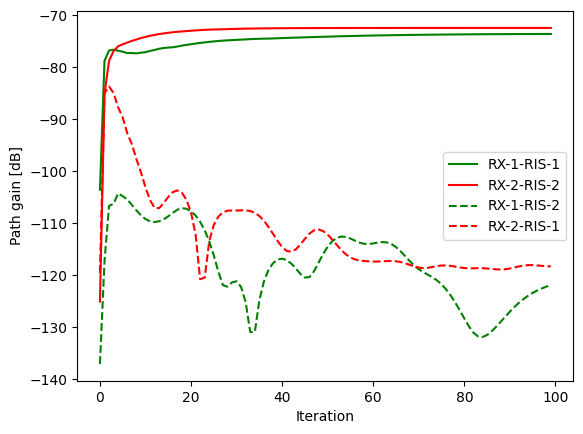

In [17]:
plt.figure()
#plt.plot(to_db(tf.abs(a_it[:,0,0])**2), "k", label="RX-1a")
#plt.plot(to_db(tf.abs(a_it[:,0,1])**2), "b", label="RX-1b")
plt.plot(to_db(tf.abs(a_it[:,0,2])**2), "g", label="RX-1-RIS-1")
plt.plot(to_db(tf.abs(a_it[:,0,3])**2), "r", label="RX-2-RIS-2")

#plt.plot(to_db(tf.abs(a_it[:,1,0])**2), "--k", label="RX-2a")
#plt.plot(to_db(tf.abs(a_it[:,1,1])**2), "--b", label="RX-2b")
plt.plot(to_db(tf.abs(a_it[:,1,2])**2), "--g", label="RX-1-RIS-2")
plt.plot(to_db(tf.abs(a_it[:,1,3])**2), "--r", label="RX-2-RIS-1")


plt.legend()
plt.xlabel("Iteration");
plt.ylabel("Path gain [dB]");
#plt.title("Path Gains");
plt.savefig("RIS_path_gains.png", dpi=300, bbox_inches='tight')
